In [75]:
import load
import data_transform as dtr
import distribution as dist
from dataframeinfo import DataFrameInfo
import transform as tr
import plotter as pl
import statsmodels.formula.api as smf
import pandas as pd
from matplotlib import pyplot as plt

loan_data = load.load_data("loan_payments_data.csv")
loan_data_cleaned = loan_data.copy()

# Describing the data

The first step is to describe the data and understand where the null values are
and what percentage of data the makeup. It is also important to make sure that 
the columns have the right datatype assigned to them. 

In [76]:
overview_loan_data_cleaned = DataFrameInfo(loan_data_cleaned)
# overview_loan_data_cleaned.stats_overview()
# overview_loan_data_cleaned.datatypes()
# overview_loan_data_cleaned.category_unique_count()
# overview_loan_data_cleaned.category_value_count()
# overview_loan_data_cleaned.null_count_percent()

# Data Transformation
After the data is loaded in as a usable dataframe, the columns need to be 
investigated and transformed where appropriate. 

For the loan_data dataset, the following columns need to be split as they 
contain a mix of strings and ints. The final format of these columns will 
be int: 
- term
- employment_length

The following columns will be converted to datetime64:
- issue_date
- earliest_credit_line
- last_payment_date
- next_payment_date
- last_credit_pull_date

The following columns will be converted to a category:
- grade
- sub_grade
- home_ownership
- verification_status
- loan_status
- purpose
- application_type
- payment_plan

The following columns will be dropped because they contain > 60% null values:
- mths_since_last_delinq
- mths_since_last_record
- next_payment_date
- mths_since_last_major_derog
- last_credit_pull_date
- collections_12_mths_ex_med

In [77]:

current_loans = dtr.DataTransform(loan_data_cleaned)
integer_columns = ["term", "employment_length"]
current_loans.extract_int(integer_columns)


# Create a list of the date columns to convert
date_columns = ["issue_date", "earliest_credit_line", "last_payment_date", \
                "next_payment_date", "last_credit_pull_date"]
current_loans.to_date_column(date_columns)

# Create a list of the category columns to convert
category_columns = ["grade", "sub_grade", "home_ownership", \
                    "verification_status", "loan_status", "purpose", \
                    "application_type", "payment_plan"]
current_loans.to_cat_column(category_columns)

# Drop columns with >60% null values
loan_data_cleaned.drop(["mths_since_last_delinq", "mths_since_last_record", \
                        "next_payment_date", "mths_since_last_major_derog", \
                        "last_credit_pull_date", "collections_12_mths_ex_med"],\
                        axis=1, inplace=True)

overview_loan_data_cleaned.datatypes()

Column Datatypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       54231 non-null  int64         
 1   member_id                54231 non-null  int64         
 2   loan_amount              54231 non-null  int64         
 3   funded_amount            51224 non-null  float64       
 4   funded_amount_inv        54231 non-null  float64       
 5   term                     49459 non-null  float64       
 6   int_rate                 49062 non-null  float64       
 7   instalment               54231 non-null  float64       
 8   grade                    54231 non-null  category      
 9   sub_grade                54231 non-null  category      
 10  employment_length        52113 non-null  float64       
 11  home_ownership           54231 non-null  category      
 12  annual_inc    

## Imputing null values

For those columns where null values are < 60% of the column, these will be 
imputed or replaced with a specified value. The following columns contain a 
low percentage of nulls:
- funded_amount
- int_rate
- employment_length

As such, the distribution and mean and median of the columns have been assessed.
This shows that there is little difference between the mean and median, 
therefore the median has been chosen to impute the nulls here.
The following columns will be assessed using other methods as they are 
non-numerical:
- term - assessed using a historam as this is a categorical column. Nulls 
imputed with the mode (36)
- last_payment_date - nulls very low therefore null rows dropped

In [78]:
col_list = ["funded_amount", "int_rate", "employment_length"]
for col in col_list:
    test = dist.DistributionChecker(loan_data_cleaned[f"{col}"])
    print(f"D'Agostino's for {col}:")
    test.dagostino()
    print(f"Distribution statistics for {col}:")
    test.mean_vs_median()

#term_hist = Plotter(loan_data_cleaned["employment_length"])
#term_hist.histogram()


D'Agostino's for funded_amount:
Statistics=4491.436, p=0.000
Distribution statistics for funded_amount:
The median is 12000.0
The mean is 13229.50911682024
D'Agostino's for int_rate:
Statistics=1421.934, p=0.000
Distribution statistics for int_rate:
The median is 13.16
The mean is 13.507328482328484
D'Agostino's for employment_length:
Statistics=265815.107, p=0.000
Distribution statistics for employment_length:
The median is 6.0
The mean is 5.7873467273041275


In [79]:
transform_loan_data = tr.DataFrameTransform(loan_data_cleaned)

impute_with_median_list = ["int_rate", "funded_amount", "employment_length"]
transform_loan_data.impute_with_median(impute_with_median_list)

replace_nulls_list = ["term"]
transform_loan_data.replace_nulls(replace_nulls_list, 36)

remove_rows_list = ["last_payment_date"]
transform_loan_data.drop_null_rows(remove_rows_list)




In [80]:
skewed_column_list = transform_loan_data.identify_skewed_columns()
#print(skewed_column_list)

for col in skewed_column_list:
    skew = loan_data_cleaned[col].skew()
    print(f"{col}:\t{skew}")

id:	2.370099396738564
member_id:	2.205131150292185
annual_inc:	8.714789478704947
delinq_2yrs:	5.376528406071888
inq_last_6mths:	3.2534212812201284
out_prncp:	2.354245218463486
out_prncp_inv:	2.3546663281192295
total_rec_int:	2.2045900621292547
total_rec_late_fee:	13.17540674709996
recoveries:	14.376981666404854
collection_recovery_fee:	27.782028399170365
last_payment_amount:	2.497342649155102


In [81]:
data_plotter = pl.Plotter(loan_data_cleaned)
# data_plotter.histogram(loan_data_cleaned["total_rec_inv"])

## Transforming skewed columns

As all the columns are positively skewed, a log transformation can be used to
transform these columns and reduce the skew. A skew threshold of 2 has been 
set to generate a list of skewed columns. 

It is a good idea to first plot these columns and see what the data looks like
before transformation. This will help with outlier identification.

After trasnformation, the dataframe can be plotted again to see where the 
outliers are. These can be removed by using the IQR method of identifying 
outliers. 

In [82]:
#data_plotter.box_plot(skewed_column_list)

In [83]:
transform_loan_data.transform_log()
#data_plotter.box_plot()  

## Identifying and removing outliers

With the standard threshold of 1.5, there are a large number of outliers in the
data. 

Increasing the threshold to 4 reduces this number and reduces the sensitivity
of the IQR method. 

For those columns where the number of outliers is < 10, these outliers are 
removed from the data. For other columns, the most extreme 1% of the data is 
removed where the outlier count is high. 

In [84]:
#transform_loan_data.identify_outliers_IQR_all_columns()
#transform_loan_data.identify_outliers_IQR_all_columns(4)
outlier_removal = tr.DataFrameTransform(loan_data_cleaned)
outlier_removal.outlier_count_per_column(4)

{'annual_inc': 10,
 'delinq_2yrs': 8588,
 'inq_last_6mths': 2,
 'open_accounts': 30,
 'total_accounts': 2,
 'total_rec_late_fee': 1761,
 'recoveries': 3612,
 'collection_recovery_fee': 3393}

In [85]:
outlier_removal.remove_outliers(4)
outlier_removal.outlier_count_per_column(4)

{'annual_inc': 10,
 'delinq_2yrs': 8268,
 'open_accounts': 1,
 'total_rec_late_fee': 1661,
 'recoveries': 3415,
 'collection_recovery_fee': 3209}

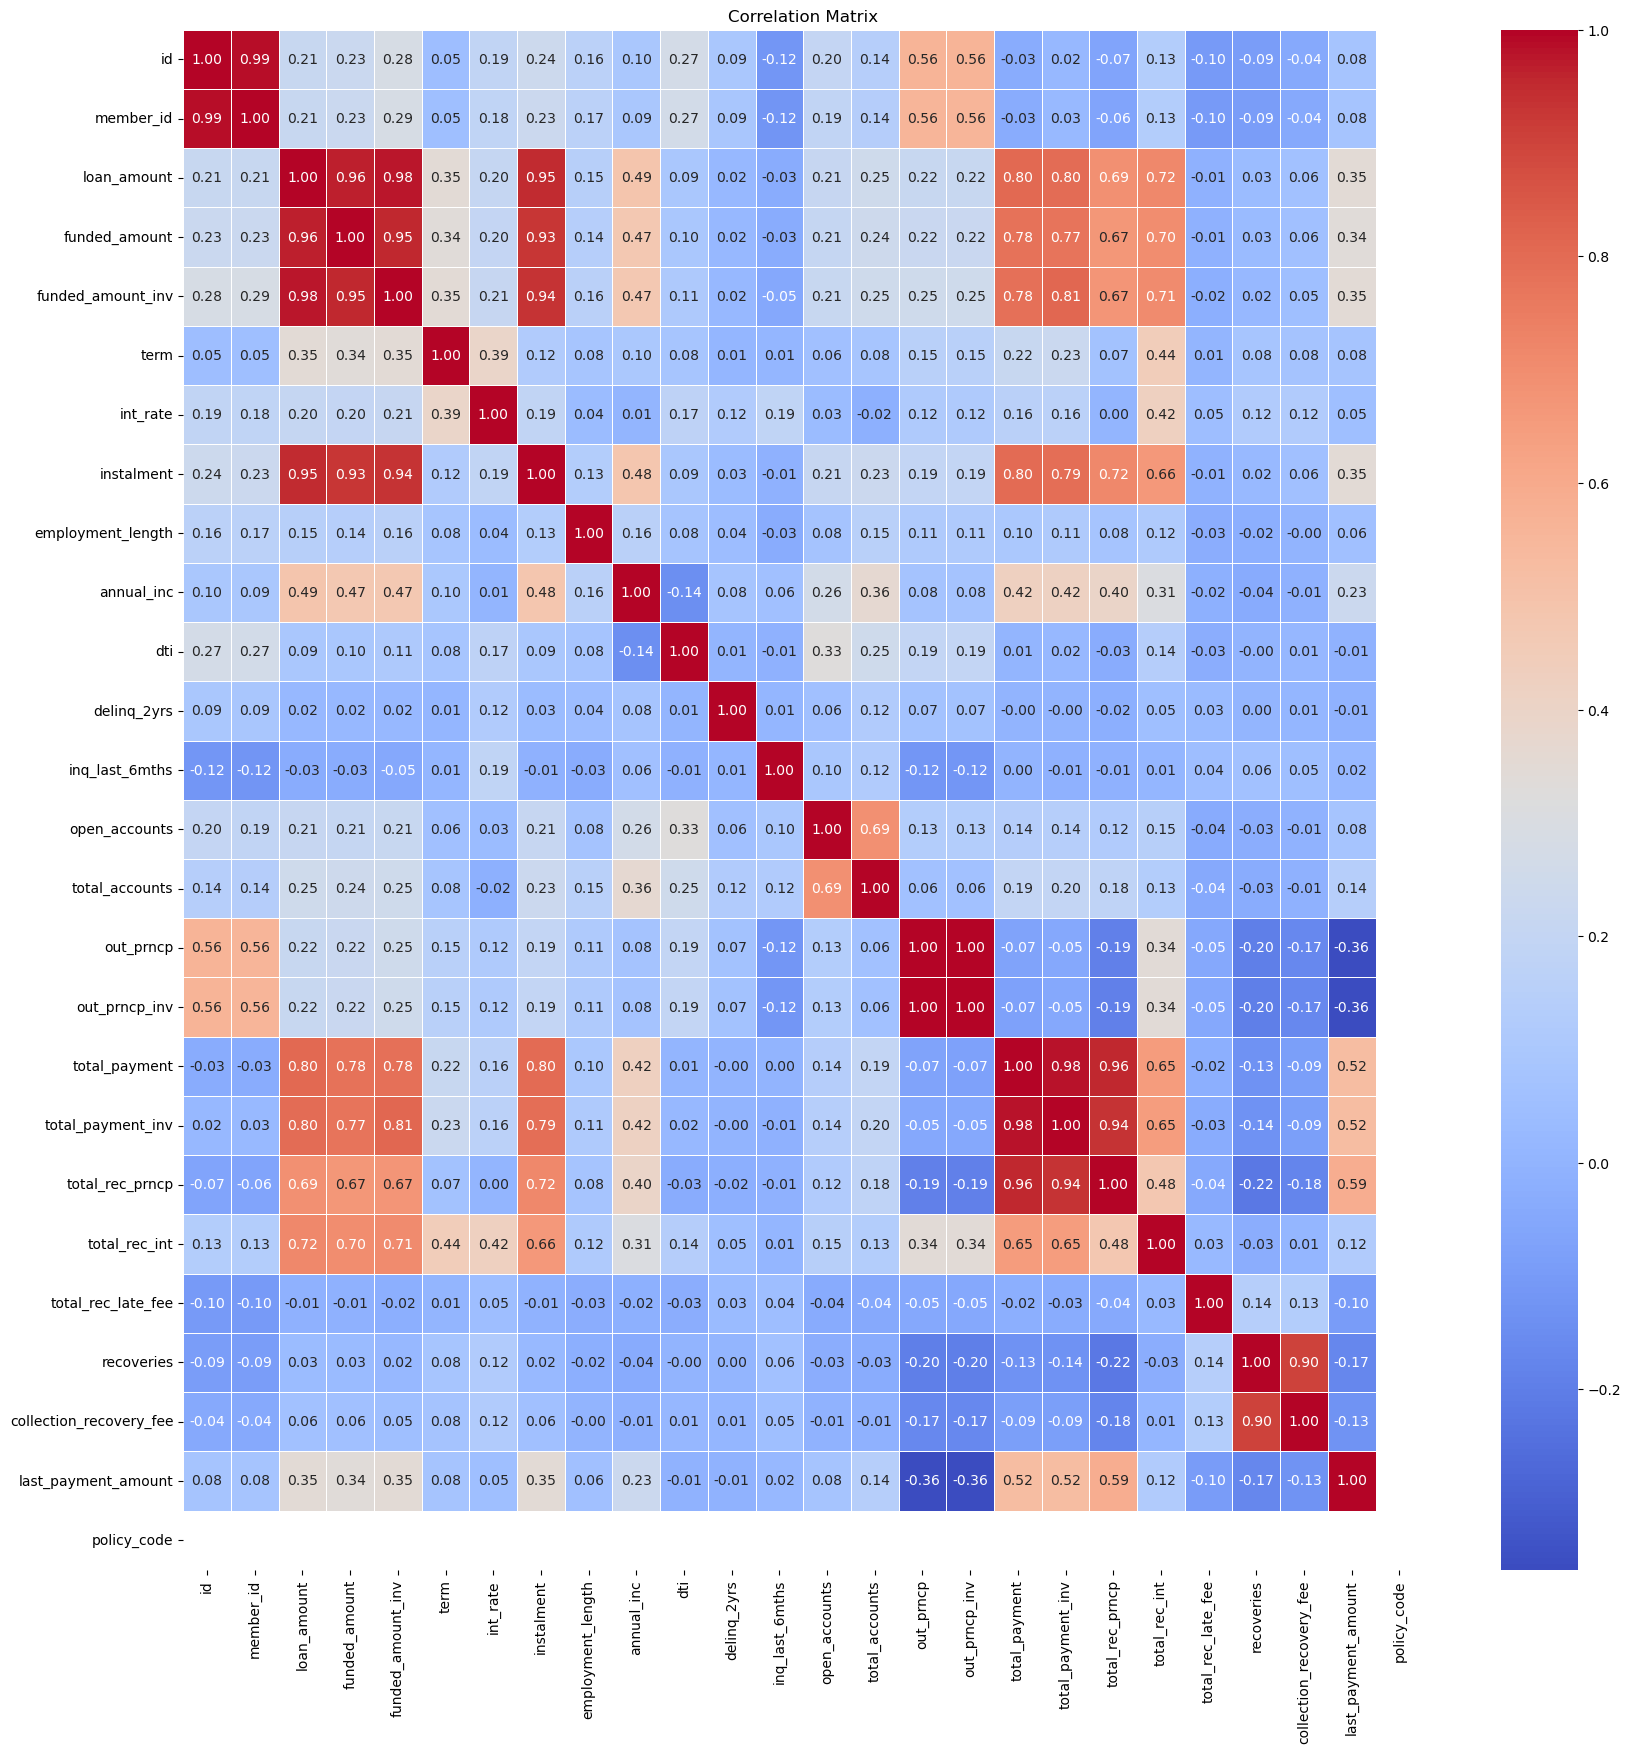

In [86]:
correlation_removal = tr.DataFrameTransform(loan_data_cleaned)
correlation_removal.identify_correlated_columns()

## Correlated columns

Due to the nature of the loans dataframe, there are several highly correlated 
columns. The remaining outstanding of the pricipal loan (out_prncp) and the 
portion of priciple outstanding for investors (out_prncp_inv) gave a correlation 
coeeficient of 1. This means that one of these variables can be dropped as 
the relationship of either variable with the rest of the dataframe can be
explained by the presence of one. 

Here, I am going to drop out_prncp_inv. 

For other correlated columns, a further dive into the corerlation is required. 
Both the R^2 and VIF values will be analysed.

Let's take a look at the other highly correlated columns below:
- recoveries and collection_recovery_fee
- loan_amount, funded_amount, and funded_amount_inv
- total_payment, total_payment_inv, and total_rec_prncp
- instalment, loan_amount, and funded_amount
- id, and member_id

In [87]:
# A VIF function will fit a linear regression model to one of the independent
# variables against others

def VIF(r2):
    return 1/(1-r2)

In [88]:
# I will assess the above in the order of bullet points.


rec_model = smf.ols("recoveries ~ collection_recovery_fee", loan_data_cleaned).fit()
coll_rec_model = smf.ols("collection_recovery_fee ~ recoveries", loan_data_cleaned).fit()

print("R^2 for model: \n recoveries: {} \n collection_recovery_fee: {}".format(rec_model.rsquared,
                                                                  coll_rec_model.rsquared))
print("VIF for model: \n recoveries: {} \n collection_recovery_fee: {}".format(VIF(rec_model.rsquared),
                                                                  VIF(coll_rec_model.rsquared)))

R^2 for model: 
 recoveries: 0.8161073270336707 
 collection_recovery_fee: 0.8161073270336698
VIF for model: 
 recoveries: 5.4379545626763495 
 collection_recovery_fee: 5.437954562676323


As the recoveries and collection_recovery_fee have high R^2 values but relatively low VIF values it could be useful to drop one. Here I will drop collection_recovery_fee.

In [89]:
loan_amount_model = smf.ols("loan_amount ~ funded_amount + funded_amount_inv", loan_data_cleaned).fit()
loan_funded_amount_model = smf.ols("funded_amount ~ loan_amount + funded_amount_inv", loan_data_cleaned).fit()
loan_funded_amount_inv_model = smf.ols("funded_amount_inv ~ funded_amount + loan_amount", loan_data_cleaned).fit()

print("R^2 for model: \n loan_amount: {} \n funded_amount: {} \n funded_amount_investors: {}".format(loan_amount_model.rsquared,
                                                                  loan_funded_amount_model.rsquared,
                                                                  loan_funded_amount_inv_model.rsquared))
print("VIF for model: \n loan_amount: {} \n funded_amount: {} \n funded_amount_investors: {}".format(VIF(loan_amount_model.rsquared),
                                                                  VIF(loan_funded_amount_model.rsquared),
                                                                  VIF(loan_funded_amount_inv_model.rsquared)))

R^2 for model: 
 loan_amount: 0.9645485595371996 
 funded_amount: 0.9341805378687286 
 funded_amount_investors: 0.9533958159932149
VIF for model: 
 loan_amount: 28.20759853324755 
 funded_amount: 15.193074625945489 
 funded_amount_investors: 21.457300912175818


Here, funded_amount has a lower VIF value than loan_amount and funded_amount_investors. As this data is interested in loans, dropping loan_amount is not a viable option. 
The other two variables refer to the amount of the loan that has been funded and again are not viable to drop. 

In [90]:
total_payment_model = smf.ols("total_payment ~ total_payment_inv + total_rec_prncp", loan_data_cleaned).fit()
total_payment_inv_model = smf.ols("total_payment_inv ~ total_payment + total_rec_prncp", loan_data_cleaned).fit()
total_rec_prncp_model = smf.ols("total_rec_prncp ~ total_payment + total_payment_inv", loan_data_cleaned).fit()

print("R^2 for model: \n total_payment: {} \n total_payment_inv: {} \n total_rec_prncp: {}".format(total_payment_model.rsquared,
                                                                  total_payment_inv_model.rsquared,
                                                                  total_rec_prncp_model.rsquared))
print("VIF for model: \n total_payment: {} \n total_payment_inv: {} \n total_rec_prncp: {}".format(VIF(total_payment_model.rsquared),
                                                                  VIF(total_payment_inv_model.rsquared),
                                                                  VIF(total_rec_prncp_model.rsquared)))


R^2 for model: 
 total_payment: 0.9745231859301834 
 total_payment_inv: 0.9633629470348791 
 total_rec_prncp: 0.9142143073973985
VIF for model: 
 total_payment: 39.251375672782395 
 total_payment_inv: 27.29477179706615 
 total_rec_prncp: 11.65695548595098


Again, here we see that total_payment is highly correlated to the other two. This is key variable in the data and will not be dropped. The next most correlated is total_payment_inv, and this also a key variable in the data and will not be dropped. 


In [91]:
instalment_model = smf.ols("instalment ~ loan_amount + funded_amount", loan_data_cleaned).fit()
loan_amount_model = smf.ols("loan_amount ~ instalment + funded_amount", loan_data_cleaned).fit()
funded_amount_model = smf.ols("funded_amount ~ instalment + loan_amount", loan_data_cleaned).fit()

print("R^2 for model: \n instalment: {} \n loan_amount: {} \n funded_amount: {}".format(instalment_model.rsquared,
                                                                  loan_amount_model.rsquared,
                                                                  funded_amount_model.rsquared))
print("VIF for model: \n total_payment: {} \n loan_amount: {} \n funded_amount: {}".format(VIF(instalment_model.rsquared),
                                                                  VIF(loan_amount_model.rsquared),
                                                                  VIF(funded_amount_model.rsquared)))

R^2 for model: 
 instalment: 0.8994107095583206 
 loan_amount: 0.9507573389325822 
 funded_amount: 0.932594764553524
VIF for model: 
 total_payment: 9.94141618465625 
 loan_amount: 20.30759464097414 
 funded_amount: 14.835642860324441


These three variables are key to the loans dataset. It is expected that they will be highly correlated. All of these columns will remain. 

The next two columns are id and member_id. These refer to the id of the loan, and the member id of the person the loan is given to. Both of these are key variables, and whilst 
they are highly correlated they will remain as they will not form part of the projection analysis. 

In [92]:
loan_data_cleaned.drop(["collection_recovery_fee"], axis=1, inplace=True)

In order to put the data through any prediction model, a column that indicates whether of not the loan has been fully paid must be generated. This can also be used to calculate the percent of fully paid off loans. 

In [93]:
loan_data_cleaned["fully_paid"] = loan_data_cleaned["loan_status"].isin(["Fully Paid"]).astype(int)

outstanding_loans = loan_data_cleaned.loc[(loan_data_cleaned["loan_status"] == "Current") | (loan_data_cleaned["loan_status"].str.contains("Late"))]
percent_fully_recovered_loans = round((loan_data_cleaned["fully_paid"].sum() / len(loan_data_cleaned["fully_paid"])) * 100, 2)
fully_recovered_loans = loan_data_cleaned["fully_paid"].sum()
print("total number of fully recovered loans: ", fully_recovered_loans)
print("Percentage of fully recovered loans: ", percent_fully_recovered_loans)


total number of fully recovered loans:  27037
Percentage of fully recovered loans:  49.92


This query has been extended to show the loans that will be paid off in 6 months.  

In [94]:
loan_data_predict_fully_paid = loan_data_cleaned.copy()
loan_data_predict_fully_paid["fully_paid_date"] = loan_data_predict_fully_paid["issue_date"] + pd.to_timedelta(loan_data_predict_fully_paid["term"]*30, unit='D')
loan_data_predict_fully_paid["months_to_repayment"] = (loan_data_predict_fully_paid["fully_paid_date"] - loan_data_predict_fully_paid["last_payment_date"]).dt.days // 30

count_loans_within_6_months = loan_data_predict_fully_paid["months_to_repayment"][
    (loan_data_predict_fully_paid["months_to_repayment"] >= 0) & 
    (loan_data_predict_fully_paid["months_to_repayment"] <= 6)
].count()

total_count = fully_recovered_loans + count_loans_within_6_months

print(f"Predicted loans paid off in 6 months: {total_count}")

Predicted loans paid off in 6 months: 30292


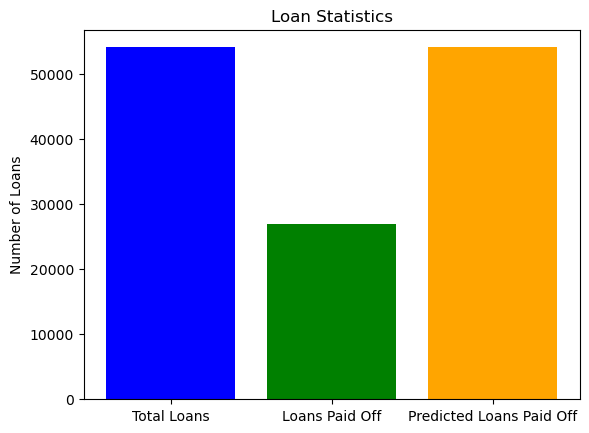

In [95]:
total_loans = len(loan_data_cleaned)

categories = ["Total Loans", "Loans Paid Off", "Predicted Loans Paid Off"]
counts = [total_loans, fully_recovered_loans, total_loans]

plt.bar(categories, counts, color=['blue', 'green', 'orange'])
plt.title('Loan Statistics')
plt.ylabel('Number of Loans')
plt.show()


Another key factor to consider when working with loan data is the percentage of defaulted loans and how this affects loss. 

In [96]:
loan_data_cleaned["loan_revenue"] = loan_data_cleaned.apply(lambda row: row["instalment"] * row["term"], axis=1)
loan_data_cleaned["remaining_revenue"] = loan_data_cleaned.apply(lambda row: row["loan_revenue"] - row["total_payment"], axis=1)
loan_data_cleaned["defaulted"] = loan_data_cleaned["loan_status"].isin(["Charged Off"]).astype(int)
defaulted_loans = loan_data_cleaned.copy()
print(f"Percentage of charged off loans: {round((len(loan_data_cleaned['defaulted'])/len(loan_data_cleaned)) * 100, 2)}%")

total_paid_before_defaulted = sum(defaulted_loans["total_payment"])
print("The total paid before loans were charged off: ", round(total_paid_before_defaulted, 2))


total_revenue = loan_data_cleaned["loan_revenue"].sum()
loss = round(defaulted_loans["remaining_revenue"].sum(), 2)
loss_percent = round(((total_paid_before_defaulted / total_revenue) * 100), 2)

print(f"Total percentage revenue loss for charged off loans: {loss_percent}%")
print("Revenue increase charged off loans would have brought to the company: ", loss)



Percentage of charged off loans: 100.0%
The total paid before loans were charged off:  654990375.24
Total percentage revenue loss for charged off loans: 70.67%
Revenue increase charged off loans would have brought to the company:  271808203.92


Assessing those borrowers that are late can be an indicator of the potential loss to the company. 

In [97]:
late_borrowers = loan_data_cleaned.loc[(loan_data_cleaned["loan_status"].str.contains("Late"))]
late_borrowers = late_borrowers.copy()
percent_late_borrowers = round((len(late_borrowers)/len(loan_data_cleaned)) * 100, 2)
print(f"Late borrowers make up {percent_late_borrowers}% of total borrowers")

projected_loss = round(late_borrowers["remaining_revenue"].sum(), 2)
projected_loss_percent = round(((projected_loss / total_revenue) * 100), 2)

print(f"Total percentage revenue loss for charged off loans: {projected_loss_percent}%")
print("Revenue increase charged off loans would have brought to the company: ", projected_loss)

total_projected_loss = loss + projected_loss
total_loss_percent = round(((total_projected_loss/total_revenue) * 100), 2) 

print(f"If those with late payments default on their loans, the total revenue loss will be: {total_loss_percent}%")

Late borrowers make up 1.27% of total borrowers
Total percentage revenue loss for charged off loans: 0.79%
Revenue increase charged off loans would have brought to the company:  7316814.49
If those with late payments default on their loans, the total revenue loss will be: 30.12%


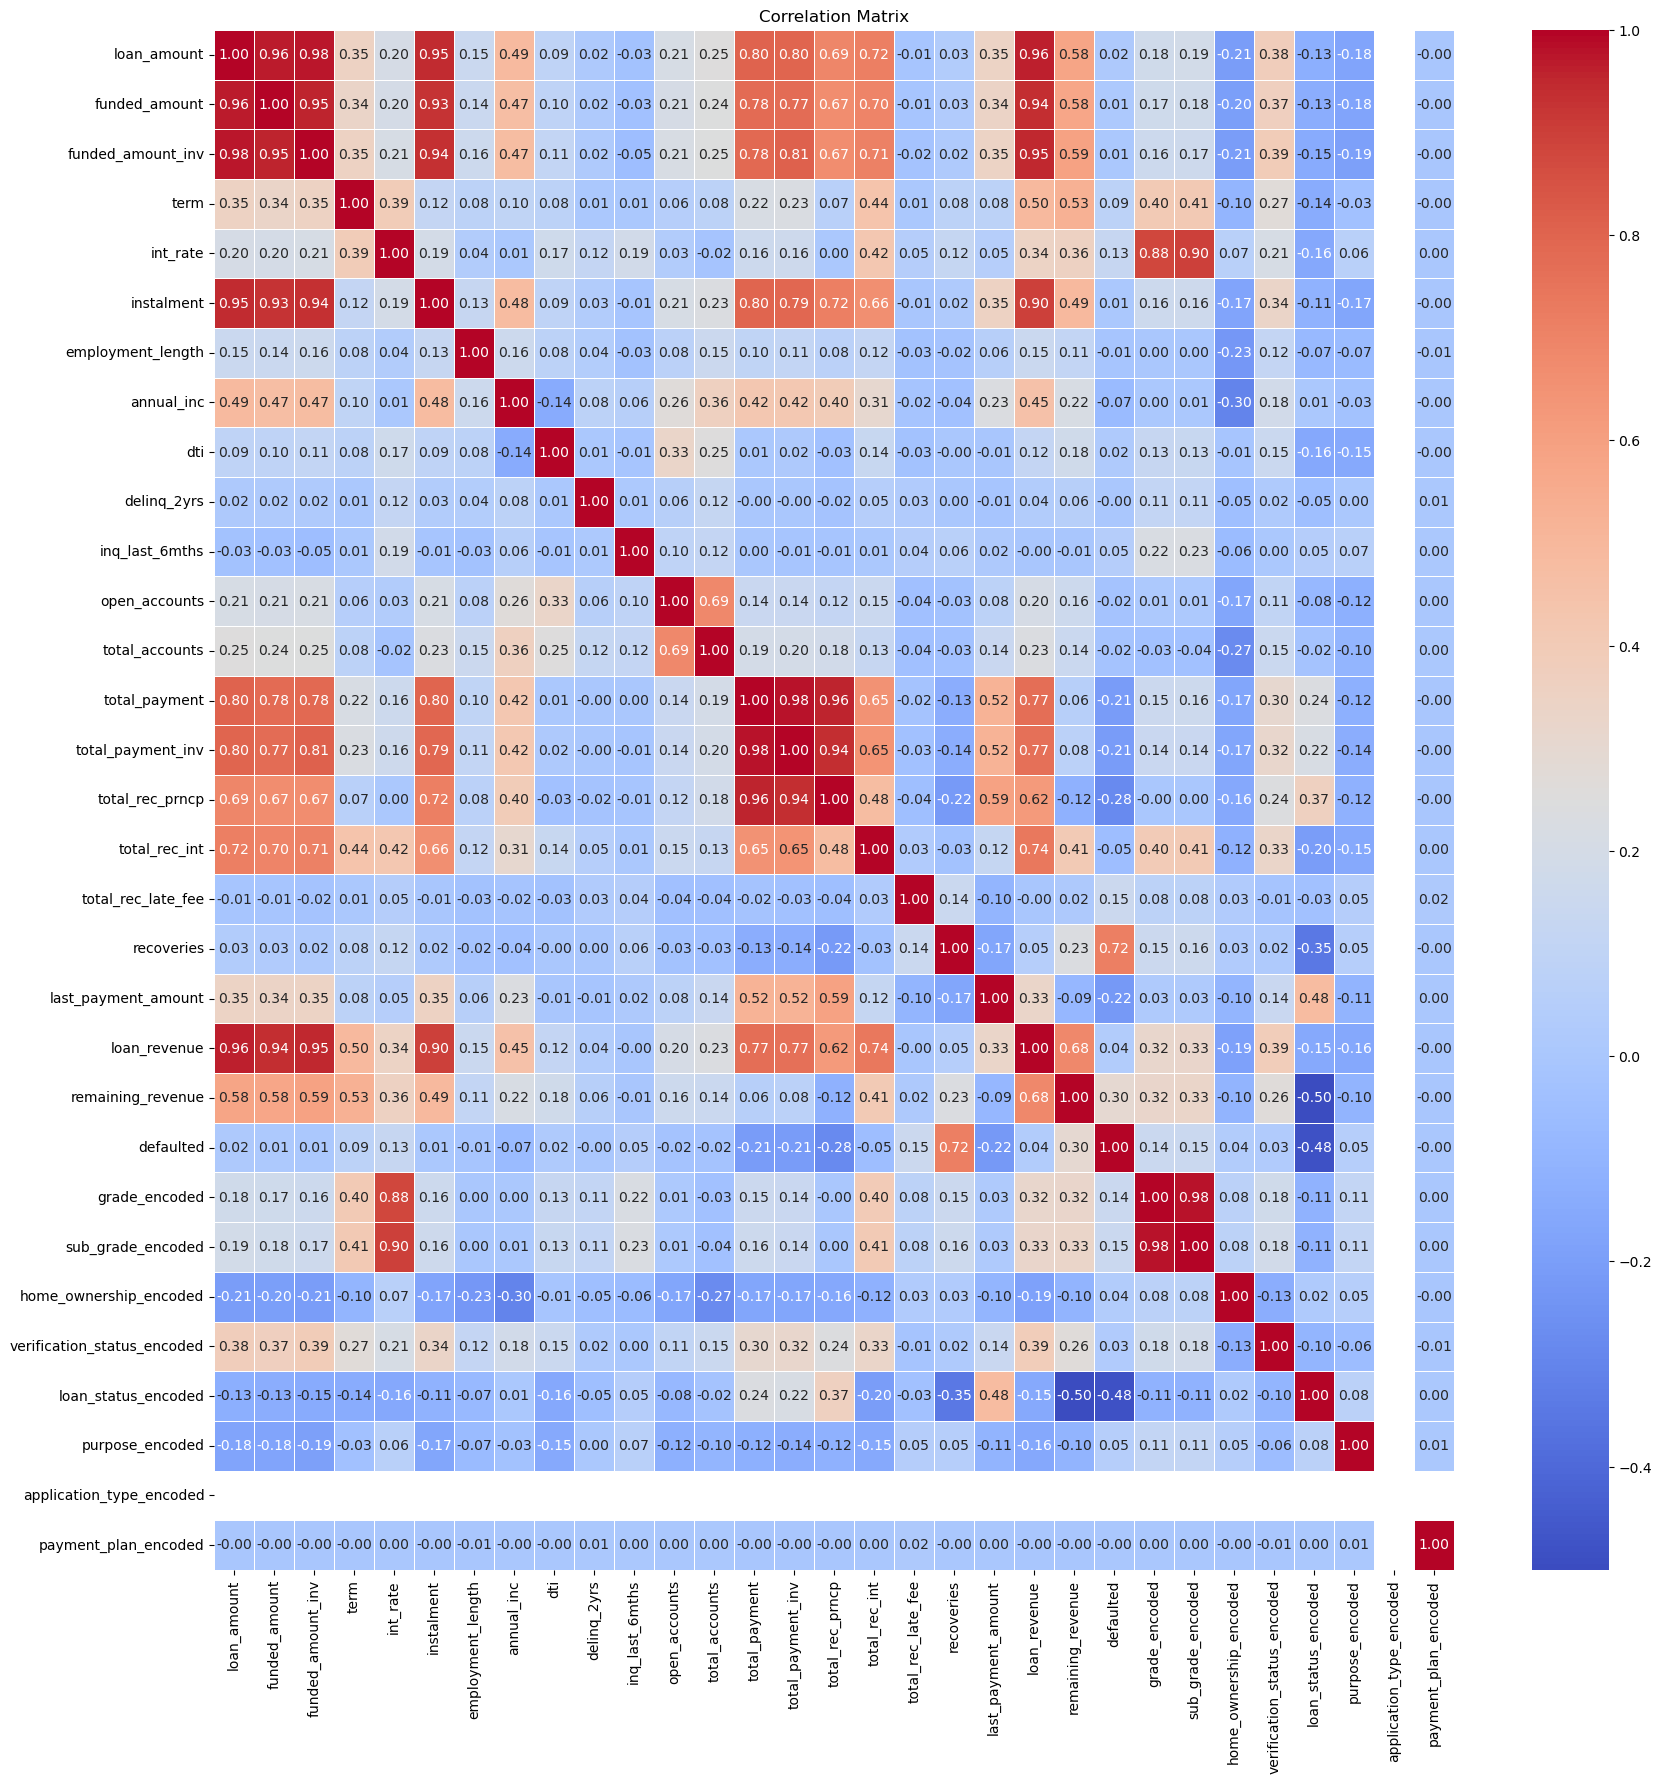

In [98]:
indicator_matrix_cleaned = defaulted_loans.drop(["id", "member_id", "out_prncp", "out_prncp_inv", "policy_code", "fully_paid"], axis=1)
defaulted_loans_encoded = tr.DataFrameTransform(indicator_matrix_cleaned)
defaulted_loans_encoded.encode_categorical_columns(category_columns)
indicator_corr = defaulted_loans_encoded.identify_correlated_columns()


Based on the above matrix, there doesn't appear to be any clear indicators to defaulting on a loan. 